In [8]:
# VGG net stolen from the TorchVision package.
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import math
import numpy as np

from utils import scale_fn
import matplotlib.pyplot as plt
import matplotlib.cm as cm


class Layer(nn.Module):
    def __init__(self, n_in, n_out, layer_index):
        super(Layer, self).__init__()
        
        self.conv1 = nn.Conv2d(n_in, n_out, kernel_size=3,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(n_out)
        
        self.layer_index = layer_index
        # If the layer is being trained or not
        self.active = True
            
    def forward(self, x):
        if not self.active:
            self.eval()
        out = F.relu(self.bn1(self.conv1(x)))
        if self.active:
            return out
        else:
            return out.detach()

# Using the VGG values provided by Sergey Zagoryuko in http://torch.ch/blog/2015/07/30/cifar.html
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    # 'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    }
# It's VGG but we call it DenseNet for compatibility with the training loop.
# I'll fix it later.
# GrowthRate and Depth are ignored.
class VGG(nn.Module):

    def __init__(self,growthRate, depth, nClasses, epochs, t_0, scale_lr=True, how_scale = 'cubic',const_time=False, cfg=cfg['E'],batch_norm=True):
        super(VGG, self).__init__()
        
        self.epochs = epochs
        self.t_0 = t_0
        self.scale_lr = scale_lr
        self.how_scale = how_scale
        self.const_time = const_time
        
        self.layer_index = 0
        self.features = self.make_layers(cfg,batch_norm)
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Dropout(),
            nn.Linear(512, nClasses),
        )
        self.classifier.layer_index = self.layer_index
        self.classifier.active = True
        self._initialize_weights()
        
        # Optimizer
        self.optim = optim.SGD([{'params':m.parameters(), 'lr':m.lr, 'layer_index':m.layer_index} for m in self.modules() if hasattr(m,'active')],  
                         nesterov=True,momentum=0.9, weight_decay=1e-4)
        # Iteration Counter            
        self.j = 0  

        # A simple dummy variable that indicates we are using an iteration-wise
        # annealing scheme as opposed to epoch-wise. 
        self.lr_sched = {'itr':0}

        self.lr_history = {i: [] for i in range(15)}#用来画图
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.log_softmax(self.classifier(x))
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
            # Set the layerwise scaling and annealing parameters
            if hasattr(m,'active'):
                m.lr_ratio = scale_fn[self.how_scale](self.t_0 + (1 - self.t_0) * float(m.layer_index) / self.layer_index)
                m.max_j = self.epochs * 400 * m.lr_ratio
                
                # Optionally scale the learning rates to have the same total
                # distance traveled (modulo the gradients).
                #m.lr = 0.1 / m.lr_ratio if self.scale_lr else 0.1
                m.lr = 0.01 / m.lr_ratio if self.scale_lr else 0.01
        

    def make_layers(self,cfg, batch_norm=False):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                # conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                # if batch_norm:
                layers += [Layer(in_channels,v,self.layer_index)]
                self.layer_index += 1
                # else:
                    # layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def update_lr(self):
    
        # Loop over all modules
        for m in self.modules():
        
            # If a module is active:
            if hasattr(m,'active') and m.active:
                #print(str(self.j)+"max_j:"+ str(m.max_j))
                # If we've passed this layer's freezing point, deactivate it.
                if self.j > m.max_j: 
                    m.active = False
                    
                    # Also make sure we remove all this layer from the optimizer
                    for i,group in enumerate(self.optim.param_groups):
                        if group['layer_index']==m.layer_index:
                            self.optim.param_groups.remove(group)   
                # If not, update the LR
                else:
                    for i,group in enumerate(self.optim.param_groups):
                        if group['layer_index']==m.layer_index:
                            self.optim.param_groups[i]['lr'] = (m.lr/2)*(1+np.cos(np.pi*self.j/m.max_j))
                            self.lr_history[m.layer_index].append(self.optim.param_groups[i]['lr'])
        # Update the iteration counter
        self.j += 1

2024-05-24 16:39:09,409 INFO| Metrics will be saved to logs/VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10_log.jsonl
2024-05-24 16:39:09,409 INFO| Running with seed 0, t_0 of 0.8, and the cubic scaling method with learning rate scaling set to True.


Loading CIFAR-10...
Files already downloaded and verified
Files already downloaded and verified


2024-05-24 16:39:11,372 INFO| Instantiating network with model VGG...
2024-05-24 16:39:11,605 INFO| Number of params: 15252426
2024-05-24 16:39:11,605 INFO| Starting training at epoch 0...


Epoch 1/15, Batch 1/900 (  0.00%) 

C:\Users\29303\AppData\Local\Temp\ipykernel_8732\3750522940.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.classifier(x))


Epoch 1/15, Batch 898/900 ( 99.67%) (ETA: 0:00) (ETA: 3:41)  (ETA: 0:37)  (ETA: 0:31)  (ETA: 0:12) 

2024-05-24 16:40:02,538 INFO| Currently have 14 active layers...


Epoch 1/15, Batch 900/900 (100.00%) (took 0:50)
  training loss:	2.263393


C:\Users\29303\AppData\Local\Temp\ipykernel_8732\1514350346.py:167: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  output = net(V(x.cuda(), volatile=True))
C:\Users\29303\AppData\Local\Temp\ipykernel_8732\1514350346.py:168: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  test_loss = F.nll_loss(output, V(y.cuda(), volatile=True)).item()


  validation loss:	1.746401
  validation error:	60.80%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 2/15, Batch 899/900 ( 99.78%) (ETA: 0:00) (ETA: 1:42)  (ETA: 0:23) 

2024-05-24 16:40:59,172 INFO| Currently have 14 active layers...


Epoch 2/15, Batch 900/900 (100.00%) (took 0:50)
  training loss:	1.944507
  validation loss:	1.479588
  validation error:	51.82%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 3/15, Batch 899/900 ( 99.78%) (ETA: 0:00)  (ETA: 0:42)  (ETA: 0:28)  (ETA: 0:26)  (ETA: 0:21)  (ETA: 0:07) 

2024-05-24 16:41:56,300 INFO| Currently have 14 active layers...


Epoch 3/15, Batch 900/900 (100.00%) (took 0:51)
  training loss:	1.541917
  validation loss:	1.409334
  validation error:	41.62%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 4/15, Batch 898/900 ( 99.67%) (ETA: 0:00) (ETA: 5:11)  (ETA: 1:00)  (ETA: 0:39)  (ETA: 0:35) 

2024-05-24 16:42:51,050 INFO| Currently have 11 active layers...


Epoch 4/15, Batch 900/900 (100.00%) (took 0:48)
  training loss:	1.264885
  validation loss:	1.087406
  validation error:	36.62%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 5/15, Batch 900/900 ( 99.89%) (ETA: 0:00) 

2024-05-24 16:43:36,960 INFO| Currently have 6 active layers...


Epoch 5/15, Batch 900/900 (100.00%) (took 0:39)
  training loss:	1.146512
  validation loss:	1.026987
  validation error:	36.06%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 6/15, Batch 898/900 ( 99.67%) (ETA: 0:00)  (ETA: 0:02) 

2024-05-24 16:44:13,602 INFO| Currently have 3 active layers...


Epoch 6/15, Batch 900/900 (100.00%) (took 0:30)
  training loss:	1.109015
  validation loss:	1.022185
  validation error:	36.06%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 7/15, Batch 900/900 ( 99.89%) (ETA: 0:00)  (ETA: 0:41)  (ETA: 0:28)  (ETA: 0:19)  (ETA: 0:16)  (ETA: 0:12)  (ETA: 0:05)  (ETA: 0:01)  (ETA: 0:01)  (ETA: 0:00) 

2024-05-24 16:44:45,793 INFO| Currently have 0 active layers...


Epoch 7/15, Batch 900/900 (100.00%) (took 0:26)
  training loss:	1.115391
  validation loss:	1.018800
  validation error:	35.70%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 8/15, Batch 898/900 ( 99.67%) (ETA: 0:00)  (ETA: 0:32)  (ETA: 0:28)  (ETA: 0:11)  (ETA: 0:04)  (ETA: 0:00) 

2024-05-24 16:45:17,325 INFO| Currently have 0 active layers...


Epoch 8/15, Batch 900/900 (100.00%) (took 0:24)
  training loss:	1.117178
  validation loss:	1.020154
  validation error:	35.58%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 9/15, Batch 897/900 ( 99.56%) (ETA: 0:00)  (ETA: 0:20) 

2024-05-24 16:45:48,752 INFO| Currently have 0 active layers...


Epoch 9/15, Batch 900/900 (100.00%) (took 0:24)
  training loss:	1.115039
  validation loss:	1.021033
  validation error:	35.94%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 10/15, Batch 899/900 ( 99.78%) (ETA: 0:00) (ETA: 1:05)  (ETA: 0:42)  (ETA: 0:34)  (ETA: 0:20)  (ETA: 0:15)  (ETA: 0:09)  (ETA: 0:01)  (ETA: 0:00) 

2024-05-24 16:46:19,923 INFO| Currently have 0 active layers...


Epoch 10/15, Batch 900/900 (100.00%) (took 0:25)
  training loss:	1.117206
  validation loss:	1.017073
  validation error:	35.80%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 11/15, Batch 900/900 ( 99.89%) (ETA: 0:00) (ETA: 1:38)  (ETA: 0:41)  (ETA: 0:13)  (ETA: 0:11)  (ETA: 0:07)  (ETA: 0:00) 

2024-05-24 16:46:50,851 INFO| Currently have 0 active layers...


Epoch 11/15, Batch 900/900 (100.00%) (took 0:24)
  training loss:	1.113321
  validation loss:	1.012662
  validation error:	35.42%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 12/15, Batch 900/900 ( 99.89%) (ETA: 0:00)  (ETA: 1:15)  (ETA: 0:41)  (ETA: 0:17)  (ETA: 0:09)  (ETA: 0:08)  (ETA: 0:04) 

2024-05-24 16:47:22,100 INFO| Currently have 0 active layers...


Epoch 12/15, Batch 900/900 (100.00%) (took 0:25)
  training loss:	1.109766
  validation loss:	1.016742
  validation error:	35.72%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 13/15, Batch 897/900 ( 99.56%) (ETA: 0:00) (ETA: 1:05)  (ETA: 1:02)  (ETA: 0:29)  (ETA: 0:27)  (ETA: 0:26)  (ETA: 0:17)  (ETA: 0:11)  (ETA: 0:08)  (ETA: 0:06) 

2024-05-24 16:47:52,894 INFO| Currently have 0 active layers...


Epoch 13/15, Batch 900/900 (100.00%) (took 0:24)
  training loss:	1.117032
  validation loss:	1.020213
  validation error:	35.62%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 14/15, Batch 900/900 ( 99.89%) (ETA: 0:00) (ETA: 2:30)  (ETA: 0:55) 

2024-05-24 16:48:24,045 INFO| Currently have 0 active layers...


Epoch 14/15, Batch 900/900 (100.00%) (took 0:25)
  training loss:	1.117616
  validation loss:	1.019554
  validation error:	35.58%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...
Epoch 15/15, Batch 896/900 ( 99.44%) (ETA: 0:00)  (ETA: 0:28)  (ETA: 0:13)  (ETA: 0:08)  (ETA: 0:03)  (ETA: 0:00) 

2024-05-24 16:48:54,831 INFO| Currently have 0 active layers...


Epoch 15/15, Batch 900/900 (100.00%) (took 0:24)
  training loss:	1.119643
  validation loss:	1.016893
  validation error:	35.60%
saving weights to VGG_k12L76_ice80_cubicTrue_seed0_epochs15C10...


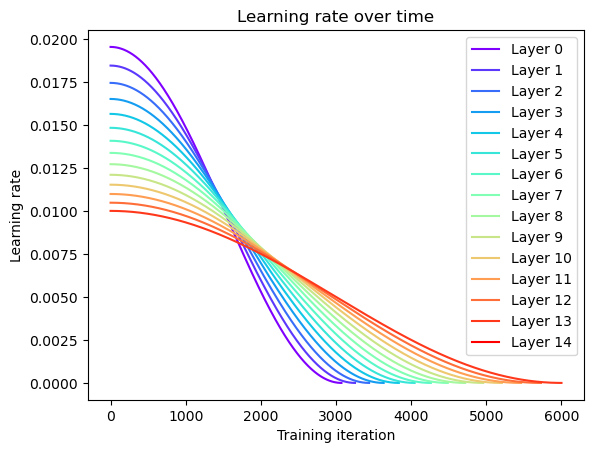

In [9]:
import os
import logging
import sys
from argparse import ArgumentParser

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from utils import get_data_loader, MetricsLogger, progress
# Set the recursion limit to avoid problems with deep nets
sys.setrecursionlimit(5000)


def opts_parser():
    usage = 'Trains and tests a FreezeOut DenseNet on CIFAR.'
    parser = ArgumentParser(description=usage)
    parser.add_argument(
        '-L', '--depth', type=int, default=76,
        help='Network depth in layers (default: %(default)s)')
    parser.add_argument(
        '-k', '--growth-rate', type=int, default=12,
        help='Growth rate in dense blocks (default: %(default)s)')
    parser.add_argument(
        '--dropout', type=float, default=0,
        help='Dropout rate (default: %(default)s)')
    parser.add_argument(
        '--augment', action='store_true', default=True,
        help='Perform data augmentation (enabled by default)')
    parser.add_argument(
        '--no-augment', action='store_false', dest='augment',
        help='Disable data augmentation')
    parser.add_argument(
        '--validate', action='store_true', default=True,
        help='Perform validation on validation set (ensabled by default)')
    parser.add_argument(
        '--no-validate', action='store_false', dest='validate',
        help='Disable validation')
    parser.add_argument(
        '--validate-test', action='store_const', dest='validate',
        const='test', help='Evaluate on test set after every epoch.')
    parser.add_argument(
        '--epochs', type=int, default=15,
        help='Number of training epochs (default: %(default)s)')
    parser.add_argument(
        '--t_0', type=float, default=0.8,
        help=('How far into training to start freezing. Note that this if using'
              +' cubic scaling then this is the uncubed value.'))
    parser.add_argument(
        '--scale_lr', type=bool, default=True,
        help='Scale each layer''s start LR as a function of its t_0 value?')
    parser.add_argument(
        '--no_scale', action='store_false', dest='scale_lr',
        help='Don''t scale each layer''s start LR as a function of its t_0 value')
    parser.add_argument(
        '--how_scale',type=str,default='cubic',
        help=('How to relatively scale the schedule of each subsequent layer.'
              +'options: linear, squared, cubic.'))
    parser.add_argument(
        '--const_time', type=bool, default=False,
        help='Scale the #epochs as a function of ice to match wall clock time.')
    parser.add_argument(
        '--seed', type=int, default=0,
        help='Random seed to use.')
    parser.add_argument(
        '--which_dataset', type=int, default=10,
        help='Which Dataset to train on (default: %(default)s)')
    parser.add_argument(
        '--batch_size', type=int, default=50,
        help='Images per batch (default: %(default)s)')
    parser.add_argument(
        '--resume', type=bool, default=False,
        help='Whether or not to resume training')
    parser.add_argument(
        '--model', type=str, default='VGG', metavar='FILE',
        help='Which model to use')
    parser.add_argument(
        '--save-weights', type=str, default='default_save', metavar='FILE',
        help='Save network weights to given .pth file')
    return parser

import time
losses = []
times = []
#用于画图

def train_test(depth, growth_rate, dropout, augment,
               validate, epochs, save_weights, batch_size, 
               t_0, seed, scale_lr, how_scale, which_dataset, 
               const_time, resume, model):
    
    # Update save_weights:
    if save_weights=='default_save':
        save_weights = (model + '_k' + str(growth_rate) + 'L' + str(depth)
                        + '_ice' + str(int(100*t_0)) + '_'+how_scale + str(scale_lr)
                        + '_seed' + str(seed) + '_epochs' + str(epochs) 
                        + 'C' + str(which_dataset))
    # Seed RNG
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
    # Name of the file to which we're saving losses and errors.
    metrics_fname = 'logs/'+save_weights + '_log.jsonl'
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s| %(message)s')
    logging.info('Metrics will be saved to {}'.format(metrics_fname))
    logging.info('Running with seed ' + str(seed) + ', t_0 of ' + str(t_0)
                + ', and the ' + how_scale + ' scaling method '
                + 'with learning rate scaling set to ' + str(scale_lr) + '.') 
    mlog = MetricsLogger(metrics_fname, reinitialize=(not resume))
   
    # Get information specific to each dataset
    train_loader,test_loader = get_data_loader(which_dataset, augment,
                                               validate, batch_size)

    # Build network, either by initializing it or loading a pre-trained
    # network.
    if resume:
        logging.info('loading network ' + save_weights + '...')
        net = torch.load(save_weights + '.pth')

        # Which epoch we're starting from
        start_epoch = net.epoch+1 if hasattr(net, 'epoch') else 0

    #  Get net
    else:
        logging.info('Instantiating network with model ' + model + '...')
        net = VGG(growth_rate, depth=depth,
                nClasses=which_dataset,
                epochs=epochs,
                t_0 = t_0,
                scale_lr = scale_lr,
                how_scale = how_scale,
                const_time = const_time)
        net = net.cuda()
        start_epoch = 0
    


    logging.info('Number of params: {}'.format(
                 sum([p.data.nelement() for p in net.parameters()]))
                 )

    # Training Function, presently only returns training loss
    # x: input data
    # y: target labels
    def train_fn(x, y):
        net.optim.zero_grad()
        output = net(V(x.cuda()))
        loss = F.nll_loss(output, V(y.cuda()))
        loss.backward()
        net.optim.step()
        # return loss.data[0]
        return loss.item()

    # Testing function, returns test loss and test error for a batch
    # x: input data
    # y: target labels
    def test_fn(x, y):
        output = net(V(x.cuda(), volatile=True))
        test_loss = F.nll_loss(output, V(y.cuda(), volatile=True)).item()

        # Get the index of the max log-probability as the prediction.
        pred = output.data.max(1)[1].cpu()
        test_error = pred.ne(y).sum()

        return test_loss, test_error

    # Finally, launch the training loop.
    logging.info('Starting training at epoch '+str(start_epoch)+'...')
    for epoch in range(start_epoch, net.epochs):
        start_time = time.time()
        # Pin the current epoch on the network.
        net.epoch = epoch

        # shrink learning rate at scheduled intervals, if desired
        train_loss = []

        # Prepare the training data
        batches = progress(
            train_loader, desc='Epoch %d/%d, Batch ' % (epoch + 1, net.epochs),
            total=len(train_loader.dataset) // batch_size)

        # Put the network into training mode
        net.train()
    
        # Execute training pass
        for x, y in batches:
        
            # Update LR if using cosine annealing
            if 'itr' in net.lr_sched:
                net.update_lr()
                
            train_loss.append(train_fn(x, y))

        # Report training metrics
        train_loss = float(np.mean(train_loss))
        losses.append(train_loss)
        # 保存时间

        times.append(time.time() - start_time)

        print('  training loss:\t%.6f' % train_loss)
        mlog.log(epoch=epoch, train_loss=float(train_loss))
        
        # Check how many layers are active
        actives = 0
        for m in net.modules():
            if hasattr(m,'active') and m.active:
                actives += 1
        logging.info('Currently have ' + str(actives) + ' active layers...')
        
        # Optionally, take a pass over the validation or test set.
        if validate:

            # Lists to store
            val_loss = []
            val_err = err = []

            # Set network into evaluation mode
            net.eval()

            # Execute validation pass
            for x, y in test_loader:
                loss, err = test_fn(x, y)
                val_loss.append(loss)
                val_err.append(err)

            # Report validation metrics
            val_loss = float(np.mean(val_loss))
            val_err =  100 * float(np.sum(val_err)) / len(test_loader.dataset)
            print('  validation loss:\t%.6f' % val_loss)
            print('  validation error:\t%.2f%%' % val_err)
            mlog.log(epoch=epoch, val_loss=val_loss, val_err=val_err)

        # Save weights for this epoch
        print('saving weights to ' + save_weights + '...')
        torch.save(net, save_weights + '.pth')

    # At the end of it all, save weights even if we didn't checkpoint.
    if save_weights:
        torch.save(net, save_weights + '.pth')

    # 获取颜色映射
    colors = cm.rainbow(np.linspace(0, 1, len(net.lr_history)))

    for layer_index, lr_list in net.lr_history.items():
        plt.plot(lr_list, color=colors[layer_index], label=f'Layer {layer_index}')
    plt.title('Learning rate over time')
    plt.xlabel('Training iteration')
    plt.ylabel('Learning rate')
    plt.legend()
    plt.show()


# parse command line
parser = opts_parser()
#args = parser.parse_args()
args, unknown = parser.parse_known_args()  # This will ignore unrecognized arguments
train_test(**vars(args))


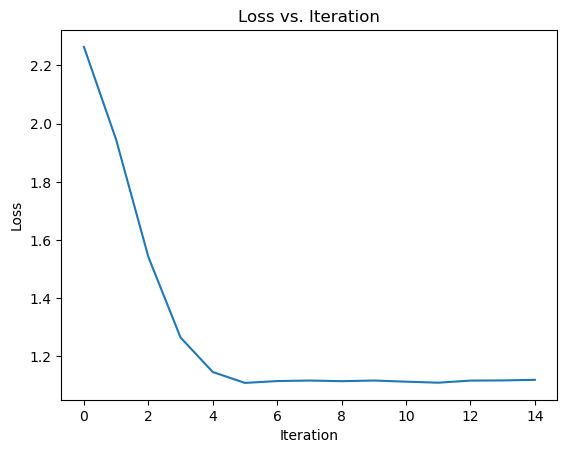

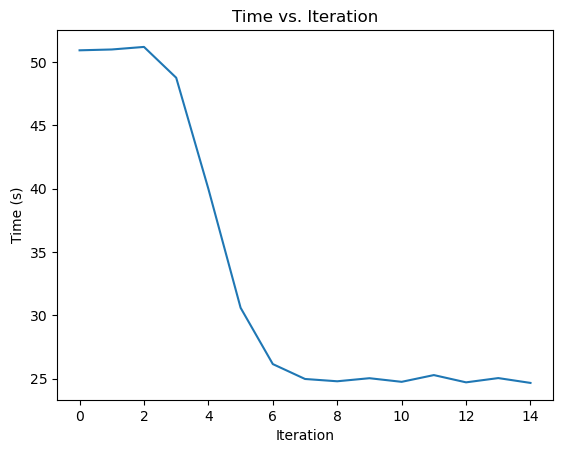

In [10]:

# 绘制损失随迭代次数变化的曲线
plt.figure()
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.show()

# 绘制每次迭代的实际耗时
plt.figure()
plt.plot(times)
plt.xlabel('Iteration')
plt.ylabel('Time (s)')
plt.title('Time vs. Iteration')
plt.show()